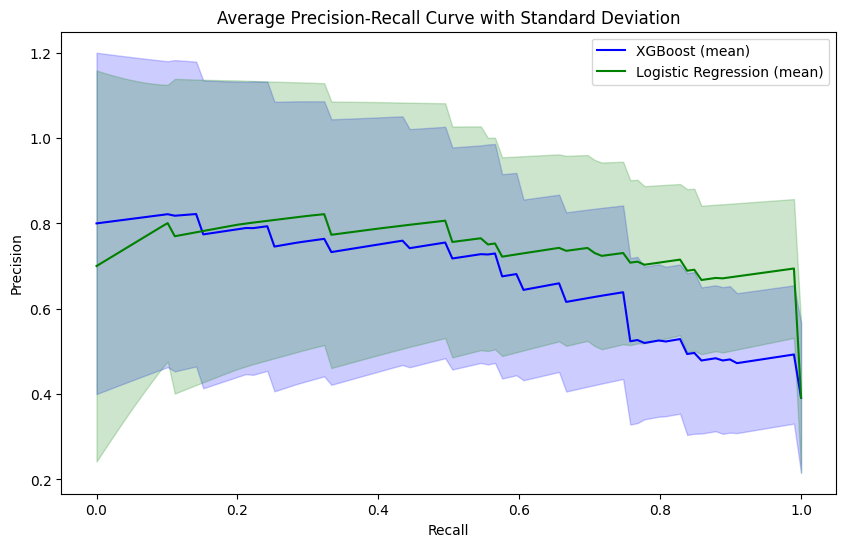

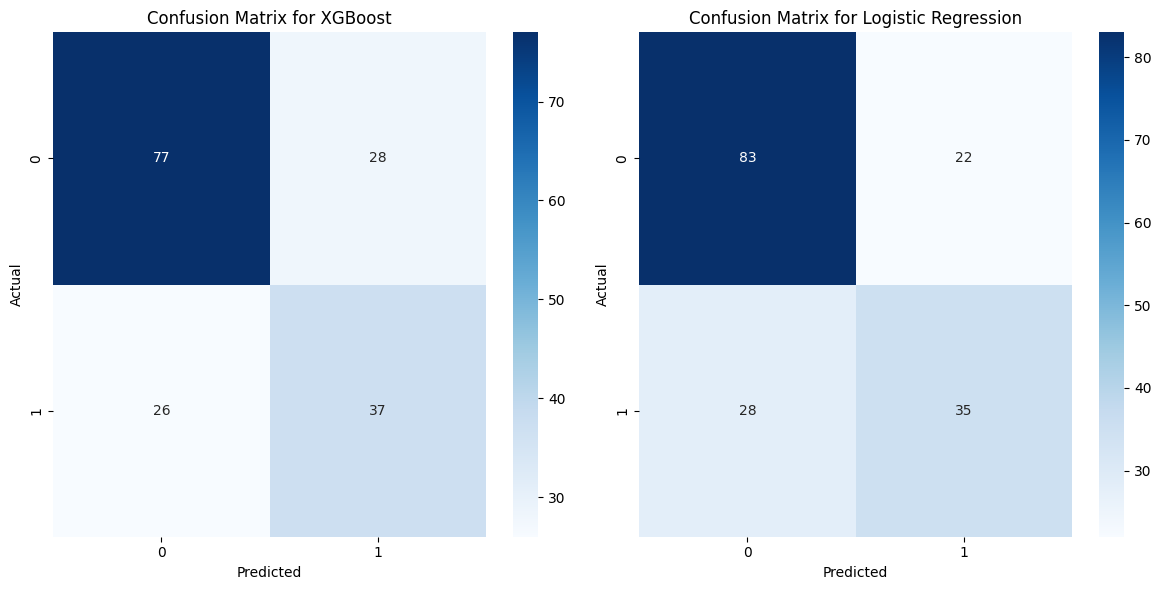

In [93]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("HR_data.csv")
df.drop(["Unnamed: 0", "Cohort"], axis=1, inplace=True)
df = pd.get_dummies(df, columns=["Round", "Phase"])
X = df.drop("Frustrated", axis=1)
y = df["Frustrated"]

# Define models
xgb_model = XGBClassifier(objective='binary:logistic')
lr_model = LogisticRegression(max_iter=10000)

# GroupKFold setup
group_kfold = GroupKFold(n_splits=10)

# Arrays to store precision-recall values for plotting average curve
xgb_precision = []
xgb_recall = []
lr_precision = []
lr_recall = []

# Arrays to store AUC scores
xgb_auc_scores = []
lr_auc_scores = []

# Arrays to store confusion matrices
xgb_conf_matrices = []
lr_conf_matrices = []

# Perform cross-validation
for train_idx, test_idx in group_kfold.split(X, y, df["Individual"]):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    threshold = y_train.median()
    y_binary_train = (y_train > threshold).astype(int)  # Define binary target
    y_binary_test = (y_test > threshold).astype(int)  # Define binary target
    
    # Train XGBoost
    xgb_model.fit(X_train, y_binary_train)
    xgb_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
    xgb_pred_binary = (xgb_pred_prob > 0.5).astype(int)
    
    # Calculate Precision-Recall AUC for XGBoost
    precision, recall, _ = precision_recall_curve(y_binary_test, xgb_pred_prob)
    xgb_precision.append(np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1]))
    xgb_auc = auc(recall, precision)
    xgb_auc_scores.append(xgb_auc)
    
    # Store XGBoost confusion matrix
    xgb_conf_matrices.append(confusion_matrix(y_binary_test, xgb_pred_binary))
    # Train Logistic Regression
    lr_model.fit(X_train, y_binary_train)
    lr_pred_prob = lr_model.predict_proba(X_test)[:, 1]
    lr_pred_binary = (lr_pred_prob > 0.5).astype(int)
    
    # Calculate Precision-Recall AUC for Logistic Regression
    precision, recall, _ = precision_recall_curve(y_binary_test, lr_pred_prob)
    lr_precision.append(np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1]))
    lr_auc = auc(recall, precision)
    lr_auc_scores.append(lr_auc)
    
    # Store Logistic Regression confusion matrix
    lr_conf_matrices.append(confusion_matrix(y_binary_test, lr_pred_binary))

# Convert lists to numpy arrays for easier calculation
xgb_precision = np.array(xgb_precision)
lr_precision = np.array(lr_precision)

# Calculate mean and std of precision
mean_xgb_precision = np.mean(xgb_precision, axis=0)
std_xgb_precision = np.std(xgb_precision, axis=0)
mean_lr_precision = np.mean(lr_precision, axis=0)
std_lr_precision = np.std(lr_precision, axis=0)

# Plotting the average Precision-Recall curve with standard deviation
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, 100), mean_xgb_precision, label=f'XGBoost (mean)', color='blue')
plt.fill_between(np.linspace(0, 1, 100), mean_xgb_precision - std_xgb_precision, mean_xgb_precision + std_xgb_precision, color='blue', alpha=0.2)
plt.plot(np.linspace(0, 1, 100), mean_lr_precision, label=f'Logistic Regression (mean)', color='green')
plt.fill_between(np.linspace(0, 1, 100), mean_lr_precision - std_lr_precision, mean_lr_precision + std_lr_precision, color='green', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Average Precision-Recall Curve with Standard Deviation')
plt.legend()
plt.show()

# Aggregate confusion matrices
agg_xgb_conf_matrix = np.sum(np.array(xgb_conf_matrices), axis=0)
agg_lr_conf_matrix = np.sum(np.array(lr_conf_matrices), axis=0)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(agg_xgb_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Confusion Matrix for XGBoost')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(agg_lr_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title('Confusion Matrix for Logistic Regression')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [94]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(xgb_auc_scores, lr_auc_scores)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation of p-value
alpha = 0.05
if p_value < alpha:
    print("The difference in performance between XGBoost and Logistic Regression is statistically significant.")
else:
    print("The difference in performance between XGBoost and Logistic Regression is not statistically significant.")

T-statistic: -1.6515752980695124
P-value: 0.1330152157802618
The difference in performance between XGBoost and Logistic Regression is not statistically significant.


Shapiro-Wilk test statistic: 0.9243471622467041
Shapiro-Wilk p-value: 0.3946418762207031
The differences are normally distributed (fail to reject H0).


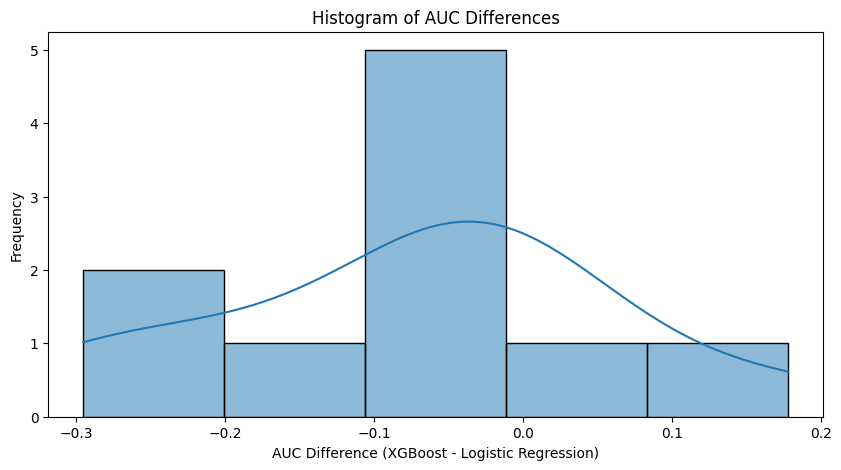

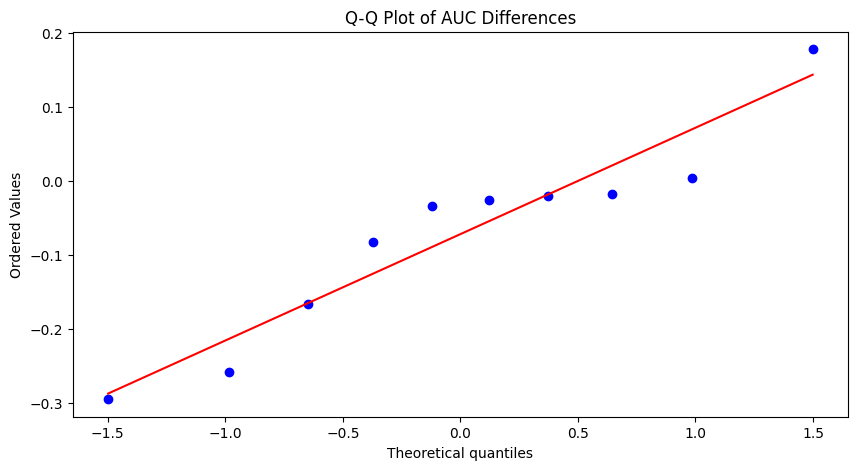

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

# Calculate the differences between the AUC scores
auc_diff = np.array(xgb_auc_scores) - np.array(lr_auc_scores)

# Perform Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = shapiro(auc_diff)
print(f"Shapiro-Wilk test statistic: {shapiro_stat}")
print(f"Shapiro-Wilk p-value: {shapiro_p_value}")

# Interpretation of p-value
alpha = 0.05
if shapiro_p_value < alpha:
    print("The differences are not normally distributed (reject H0).")
else:
    print("The differences are normally distributed (fail to reject H0).")

# Plotting histogram
plt.figure(figsize=(10, 5))
sns.histplot(auc_diff, kde=True)
plt.title('Histogram of AUC Differences')
plt.xlabel('AUC Difference (XGBoost - Logistic Regression)')
plt.ylabel('Frequency')
plt.show()

# Plotting Q-Q plot
plt.figure(figsize=(10, 5))
probplot(auc_diff, dist="norm", plot=plt)
plt.title('Q-Q Plot of AUC Differences')
plt.show()